# David Fox - EV usage and revenue data exploration
By performing dataframe manipulations, aggregations, and basic investigations I evaluate the relationship between daily revenue and several features, including temporal features and external factors (temperature, weather).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit


from sklearn.impute import SimpleImputer

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, explained_variance_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import make_scorer

from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator


from scipy.stats import kruskal, pearsonr, randint, uniform, chi2_contingency, boxcox, f_oneway, ttest_ind


import datetime

from sklearn import set_config
set_config(display='diagram') 

plt.rcParams['figure.figsize'] = [20, 20]

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')


sns.set(rc={'figure.figsize':(20, 10)})
sns.set_context("poster")
sns.set_style("white")
palette = sns.color_palette("mako_r", 6)

In [2]:
def import_data():

    df1 = pd.read_csv('data/Fort Collins Utilities EV Data June 2020 to June 2021.csv')
    df2 = pd.read_csv('data/Fort Collins Utilities EV Data June 25 2021 to July 20 2021.csv')
    df3 = pd.read_csv('data/FCU EV Charging Transaction Data July 20 2021 to Sept 2021.csv')
    
    charging_df = pd.concat([df1, df2, df3])
    charging_df = charging_df.rename(columns={'Session/Reservation Start Date': 'Date'})
    charging_df = ( charging_df.set_index(pd.to_datetime(charging_df['Date']))
                               .groupby('Station Name')
                               .resample('1D').sum()
                               .reset_index()
                  )
    
    weather_df = pd.read_csv('data/weather.csv')
    weather_df = weather_df.rename(columns={'DATE':'Date'})
    weather_df['Date'] = pd.to_datetime(weather_df['Date'])
               
    df_covid = pd.read_csv('data/cases100k-7-day-rate.csv')
    df_covid = df_covid.rename(columns={"Cases/100K: 7-Day":"cases_per_100k"})
    df_covid['Date'] = pd.to_datetime(df_covid.DateTime).dt.strftime("%Y-%m-%d")
    df_covid['Date'] = pd.to_datetime(df_covid.Date)
                    
    df = (charging_df.merge(weather_df, on='Date', how='inner')
                     .merge(df_covid, on='Date', how='inner')
         )

    return df

In [3]:
df = import_data()

In [4]:
df = (df.set_index(pd.to_datetime(df['Date']))
         .dropna(how='all')
     )

In [5]:
df.head()

,Station Name,Date,Energy (kWh),Gross Amount,Flex Billing Service Fee,Net Revenue,Exchange Rate (USD1.000),STATION,NAME,LATITUDE,...,ELEVATION,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT03,DateTime,cases_per_100k
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-25,FORT COLLINS / CIVIC CENTER,2020-06-25,30.023,4.89,0.48,4.41,2.0,USC00053005,"FORT COLLINS, CO US",40.5763,...,1525.2,0.3,0.0,0.0,30.6,12.8,22.8,NaN,2020-06-25 06:00:00,9.799184
2020-06-26,FORT COLLINS / CIVIC CENTER,2020-06-26,8.001,2.00,0.20,1.80,2.0,USC00053005,"FORT COLLINS, CO US",40.5763,...,1525.2,0.3,0.0,0.0,25.0,12.8,21.1,NaN,2020-06-26 06:00:00,11.199067
2020-06-26,FORT COLLINS / FIREHOUSE ALLEY,2020-06-26,12.713,2.07,0.21,1.86,1.0,USC00053005,"FORT COLLINS, CO US",40.5763,...,1525.2,0.3,0.0,0.0,25.0,12.8,21.1,NaN,2020-06-26 06:00:00,11.199067
2020-06-27,FORT COLLINS / CIVIC CENTER,2020-06-27,13.626,2.25,0.22,2.03,1.0,USC00053005,"FORT COLLINS, CO US",40.5763,...,1525.2,0.0,0.0,0.0,30.0,11.7,24.4,1.0,2020-06-27 06:00:00,11.199067
2020-06-27,FORT COLLINS / FIREHOUSE ALLEY,2020-06-27,10.573,1.75,0.17,1.58,1.0,USC00053005,"FORT COLLINS, CO US",40.5763,...,1525.2,0.0,0.0,0.0,30.0,11.7,24.4,1.0,2020-06-27 06:00:00,11.199067


In [6]:
df.dtypes

Station Name                        object
Date                        datetime64[ns]
Energy (kWh)                       float64
Gross Amount                       float64
Flex Billing Service Fee           float64
Net Revenue                        float64
Exchange Rate (USD1.000)           float64
STATION                             object
NAME                                object
LATITUDE                           float64
LONGITUDE                          float64
ELEVATION                          float64
PRCP                               float64
SNOW                               float64
SNWD                               float64
TMAX                               float64
TMIN                               float64
TOBS                               float64
WT03                               float64
DateTime                            object
cases_per_100k                     float64
dtype: object

In [7]:
df.isnull().sum()

Station Name                   0
Date                           0
Energy (kWh)                   0
Gross Amount                   0
Flex Billing Service Fee       0
Net Revenue                    0
Exchange Rate (USD1.000)       0
STATION                        0
NAME                           0
LATITUDE                       0
LONGITUDE                      0
ELEVATION                      0
PRCP                           0
SNOW                           0
SNWD                           0
TMAX                           0
TMIN                           0
TOBS                           0
WT03                        3407
DateTime                       0
cases_per_100k                 0
dtype: int64

# 1. Comparing revenue across stations
## Plot the revenue for each station over time

In [18]:
df2 =  ( df.groupby('Station Name')['Net Revenue'].resample('1D').sum().reset_index()
             .assign(Station_Name = lambda x: x['Station Name'].str.replace('FORT COLLINS /',''))
             .set_index('Date')
             .assign(Date = lambda x: x.index)
        )



In [19]:
df2['revenue_7D'] = df2.groupby('Station Name')['Net Revenue'].transform(lambda x: 
                                                      x.rolling('7D', closed='both', center=True).mean())

# Find the stations with the biggest weekly increase in revenue

In [28]:
df2['week_number'] = df2['Date'].apply(lambda x: int((x - df.iloc[0]['Date']) / np.timedelta64(1, 'W')))
df2['month_number'] = df2['Date'].apply(lambda x: int((x - df.iloc[0]['Date']) / np.timedelta64(1, 'M')))

In [42]:
df2["Quarter"] = df2.Date.dt.quarter

In [25]:
test_df = df2.loc[df2.week_number.isin([63, 64]), ['Station Name', 'week_number', 'revenue_7D']]
test_df = test_df.groupby(['Station Name', 'week_number'])['revenue_7D'].sum().unstack()
test_df['percent_change'] = (test_df[64] - test_df[63]) / test_df[63] * 100

In [27]:
test_df.sort_values(by='percent_change', ascending=False)

week_number,63,64,percent_change
Station Name,,,
FORT COLLINS / FIREHOUSE ALLEY,26.047143,52.707857,102.355619
FORT COLLINS / MULBERRY POOL,4.142857,6.779976,63.654598
FORT COLLINS / EPIC ICE CENTER,8.050000,11.569952,43.726117
FORT COLLINS / PRPA WEST,2.062857,2.339000,13.386427
FORT COLLINS / PRPA EAST,18.680000,17.291405,-7.433593
FORT COLLINS / CIVIC CENTER,50.191429,44.517190,-11.305193
FORT COLLINS / SENIOR CENTER,7.278571,4.055571,-44.280667
FORT COLLINS / SOUTH TRANSIT,6.591429,0.771429,-88.296489


Based on this table, we should monitor the stations at South Transit and the Senior center. As part of an analytics dashboard, i would have an annotation on the plot of revenue showing the percent change on the previous week/month

### Even though PRPA EAST is not consistently a top performing station (see facetgrid plots directly below), it has shown the 2nd largest increase over last month

In [33]:
test_df = df2.loc[df2.month_number.isin([13, 14]), ['Station Name', 'month_number', 'revenue_7D']]
test_df = test_df.groupby(['Station Name', 'month_number'])['revenue_7D'].sum().unstack()
test_df['percent_change'] = (test_df[14] - test_df[13]) / test_df[13] * 100

test_df.sort_values(by='percent_change', ascending=False)

month_number,13,14,percent_change
Station Name,,,
FORT COLLINS / FIREHOUSE ALLEY,117.332857,182.899286,55.880706
FORT COLLINS / PRPA EAST,52.062857,73.731405,41.619974
FORT COLLINS / SOUTH TRANSIT,12.221429,14.144286,15.733489
FORT COLLINS / PRPA WEST,15.152857,14.440429,-4.701612
FORT COLLINS / CIVIC CENTER,262.262857,224.908619,-14.243053
FORT COLLINS / MULBERRY POOL,36.105714,17.235690,-52.263261
FORT COLLINS / SENIOR CENTER,97.447143,45.568429,-53.237799
FORT COLLINS / EPIC ICE CENTER,110.294286,48.751381,-55.798815


In [46]:
test_df = df2.loc[df2.Quarter.isin([2, 3]), ['Station Name', 'Quarter', 'revenue_7D']]
test_df = test_df.groupby(['Station Name', 'Quarter'])['revenue_7D'].sum().unstack()
test_df['percent_change'] = (test_df[3] - test_df[2]) / test_df[2] * 100

test_df.sort_values(by='percent_change', ascending=False)

Quarter,2,3,percent_change
Station Name,,,
FORT COLLINS / PRPA WEST,6.161429,36.373619,490.343921
FORT COLLINS / SOUTH TRANSIT,16.310000,51.329786,214.713585
FORT COLLINS / PRPA EAST,58.602857,162.070714,176.557701
FORT COLLINS / FIREHOUSE ALLEY,235.092762,526.259286,123.851760
FORT COLLINS / EPIC ICE CENTER,113.305714,231.131381,103.989165
FORT COLLINS / SENIOR CENTER,134.001429,214.234548,59.874824
FORT COLLINS / CIVIC CENTER,707.622452,918.994333,29.870714
FORT COLLINS / MULBERRY POOL,168.801429,167.606738,-0.707749


## Visualizing revenue generated from each of the stations
When you look at changes over quarters, then the poorest performing stations come out looking good because they didn't have much usage several months ago. PRPA EAST is up there though and you can see visually from the plot below that there does seem to be an exponential increase as covid cases start to decrease.

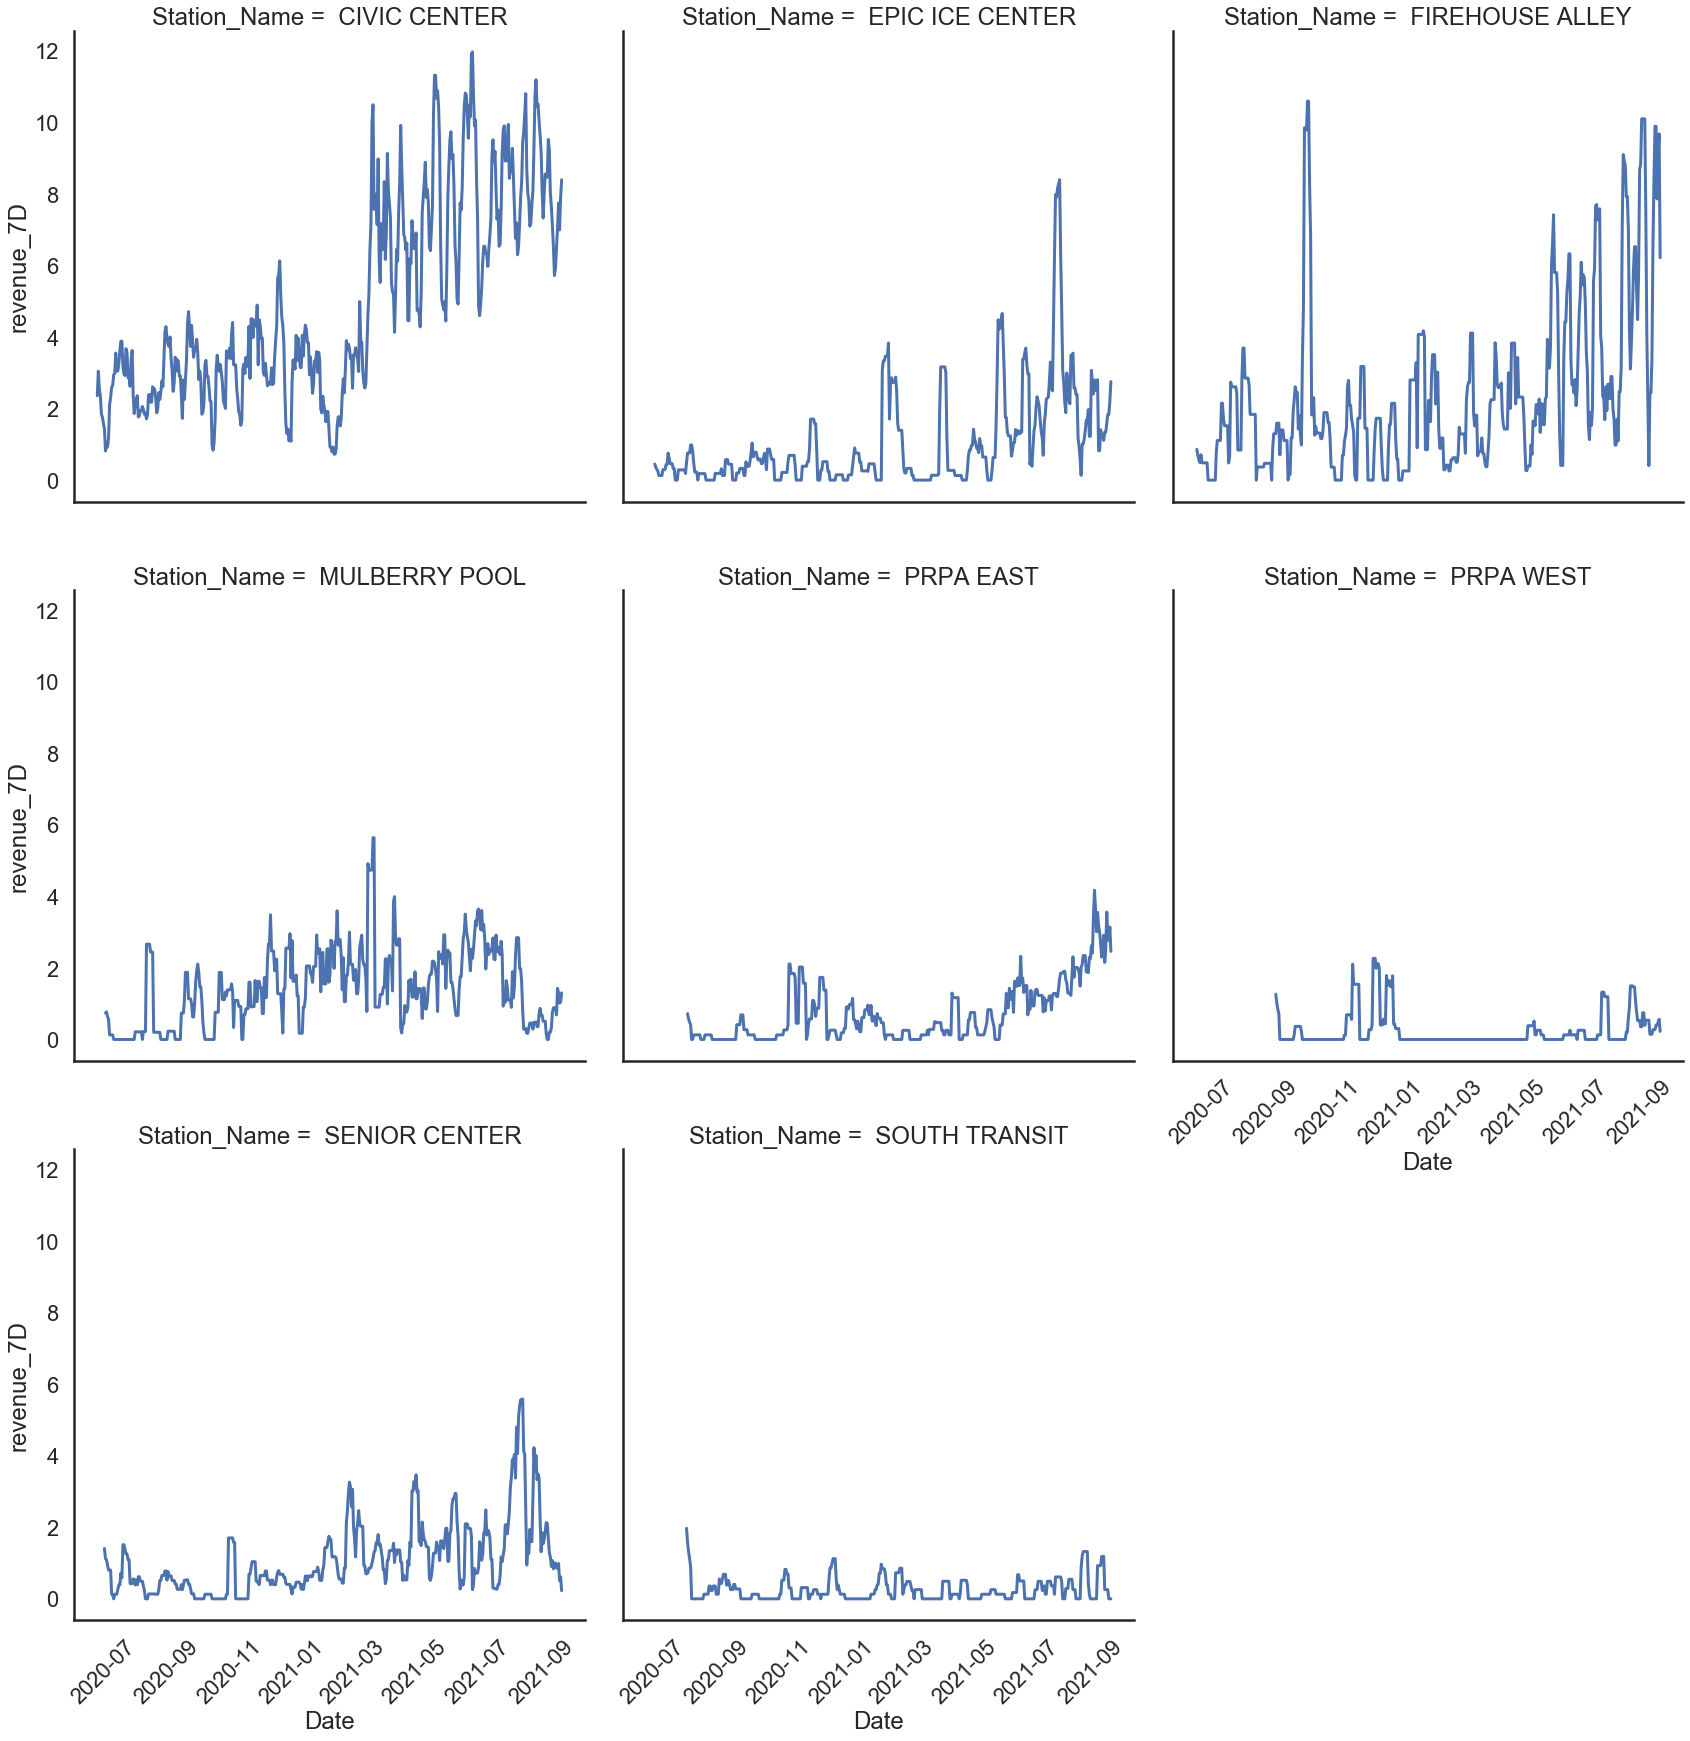

In [297]:
with sns.axes_style("white"):
    g = sns.FacetGrid(df2, col="Station_Name", margin_titles=True, 
                      height=8, sharey=True, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue_7D")

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45);
    

## Identify the best and worst performing stations

In [61]:
test =  df.groupby('Station Name')['Net Revenue'].resample('1D').size().reset_index()

In [62]:
last7days = test[test["Date"] >= (test.iloc[-1]['Date'] - pd.Timedelta(days=7))]

Text(0.5, 1.0, 'number of visits at each station over the last week')

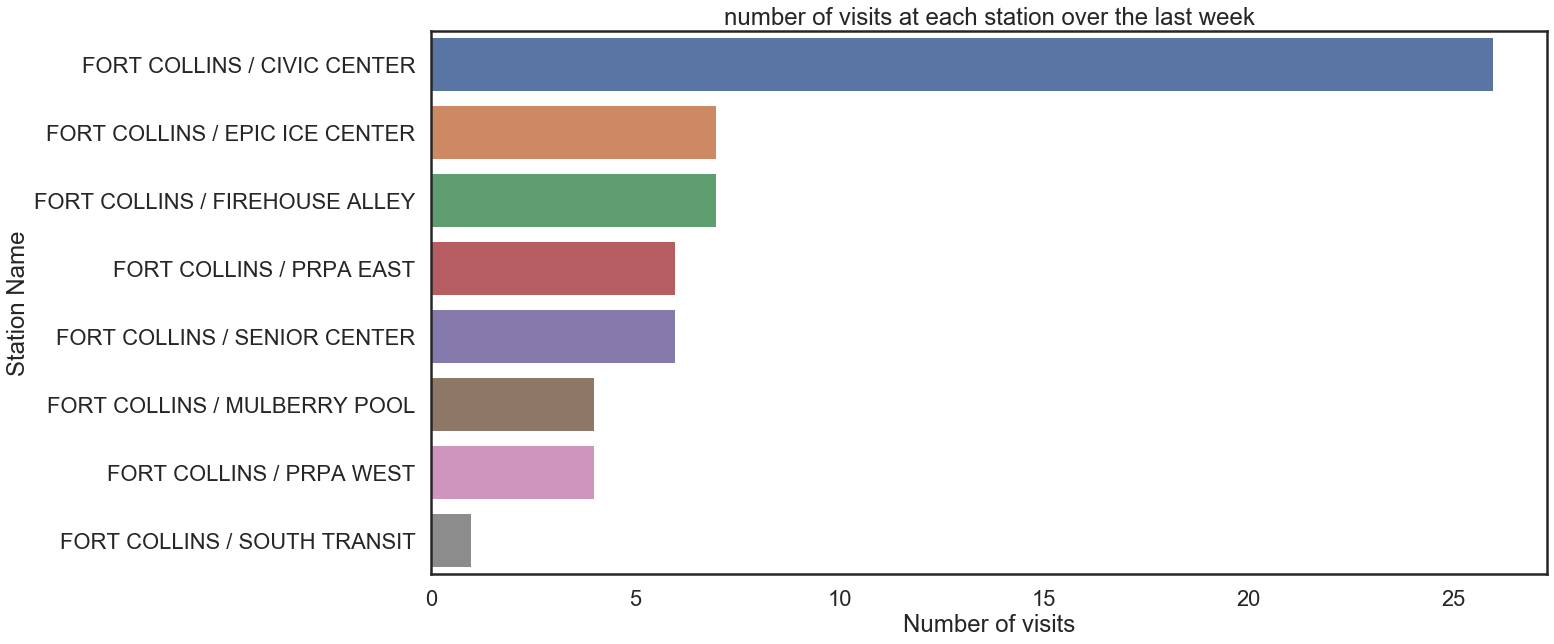

In [63]:
test2 = ( last7days.groupby('Station Name')['Net Revenue'].sum()
                                                     .reset_index()
                                                     .rename(columns={'Net Revenue' : 'Number of visits'})
                                                     .sort_values(by='Number of visits', ascending=False)
        )
ax = sns.barplot(x="Number of visits", y="Station Name", data=test2, capsize=.2)    
plt.title("number of visits at each station over the last week")

### civic center is getting 26 sessions in the last week, whereas the station at South Transit is hardly being used! This station is probably not worth the money!
The next lowest are PRPA west and Mulberry pool. Inspecting the revenue over time, it looks like PRPA west is consistently low, but the station at Mulberry pool seems to be experiencing only a temporary decrease in revenue.

## Show weekly revenue from each station in the last week

In [73]:
last7days = df2[df2["Date"] >= (df2.iloc[-1]['Date'] - pd.Timedelta(days=7))]


Text(0.5, 1.0, 'Weekly Total Revenue By Station')

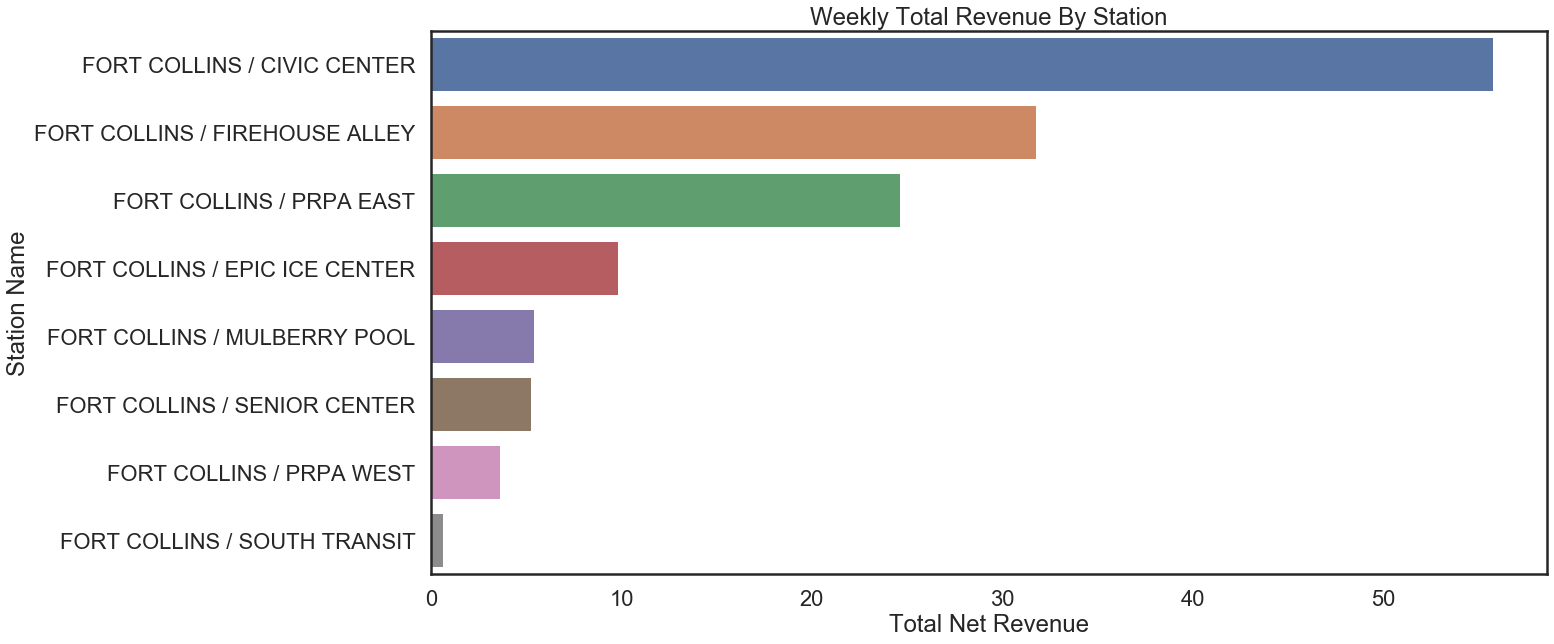

In [75]:
test2 = ( last7days.groupby('Station Name')['revenue_7D'].sum()
                                                     .reset_index()
                                                     .rename(columns={'revenue_7D' : 'Total Net Revenue'})
                                                     .sort_values(by='Total Net Revenue', ascending=False)
        )
ax = sns.barplot(x="Total Net Revenue", y="Station Name", data=test2, capsize=.2)   
plt.title('Weekly Total Revenue By Station')

## plot the average duration of charging sessions per station and per weekday and weekend

In [76]:
df['duration'] = (pd.to_datetime(df['Session/Reservation End Date'].str[:-6]) - pd.to_datetime(df['Date'])) / pd.Timedelta(hours=1)

In [77]:
test =  df.groupby('Station Name')['duration'].resample('1D').mean().reset_index()

In [88]:
last7days = test[test["Date"] >= (test.iloc[-1]['Date'] - pd.Timedelta(days=7))]

In [89]:
last7days['is_weekend'] = last7days['Date'].dt.dayofweek > 4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Average duration By Station over the last week')

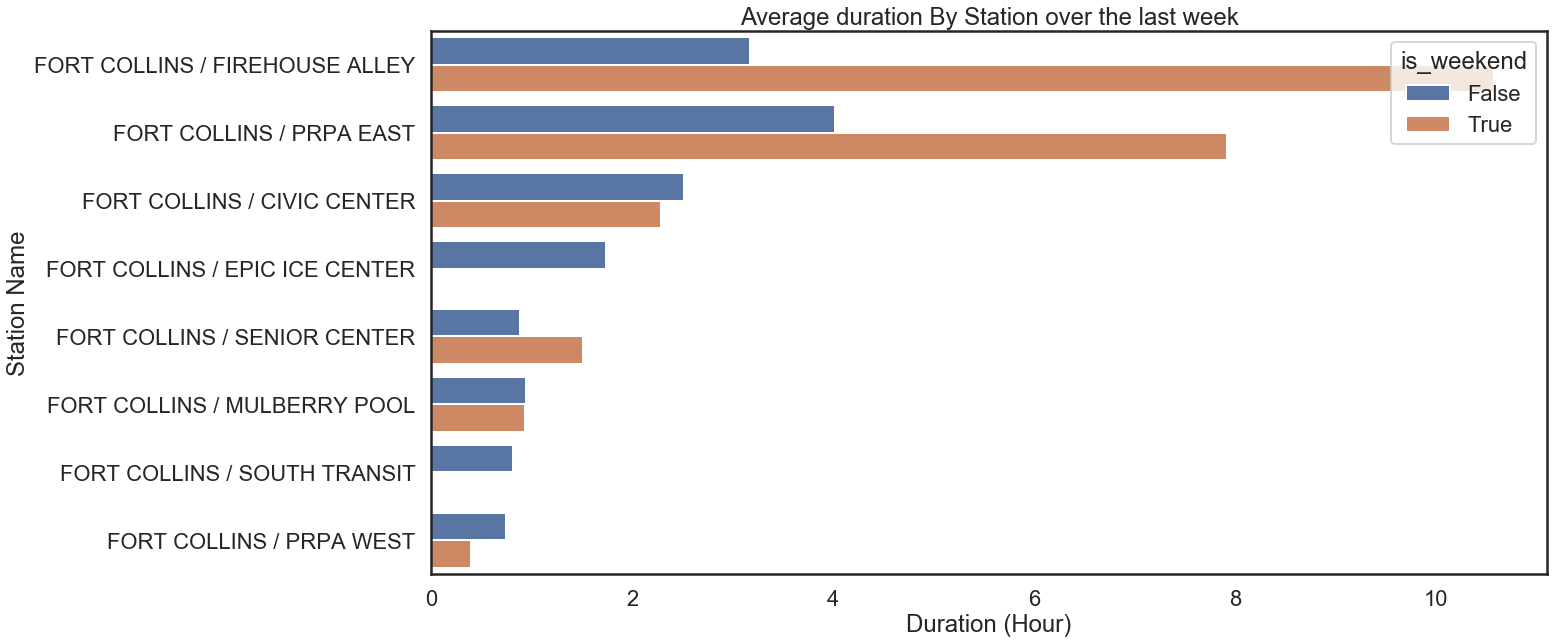

In [92]:
test2 = ( last7days.groupby(['Station Name', 'is_weekend'])['duration'].mean()
                                                     .reset_index()
                                                     .rename(columns={'duration' : 'Duration (Hour)'})
                                                     .sort_values(by='Duration (Hour)', ascending=False)
        )
ax = sns.barplot(x="Duration (Hour)", y="Station Name", hue='is_weekend', data=test2, capsize=.2)   
plt.title('Average duration By Station over the last week')

### individual charging sessions are the same or longer on the weekend compared to that for the working weekday.
This is the case for the following stations:
- Firehouse Alley
- PRPA East
- Civic Center
- Senior Center
- Mulberry Pool

For some reason in the last week, the stations located at the ice center and south transit were not used on the weekend. PRPA West station seems to be used more during weekdays suggesting to me that it is not located close to places of public gathering or local business.


# 2. Month of year
## Total amount of revenue is larger during the summer months.
This is why month of the year should be included as a feature

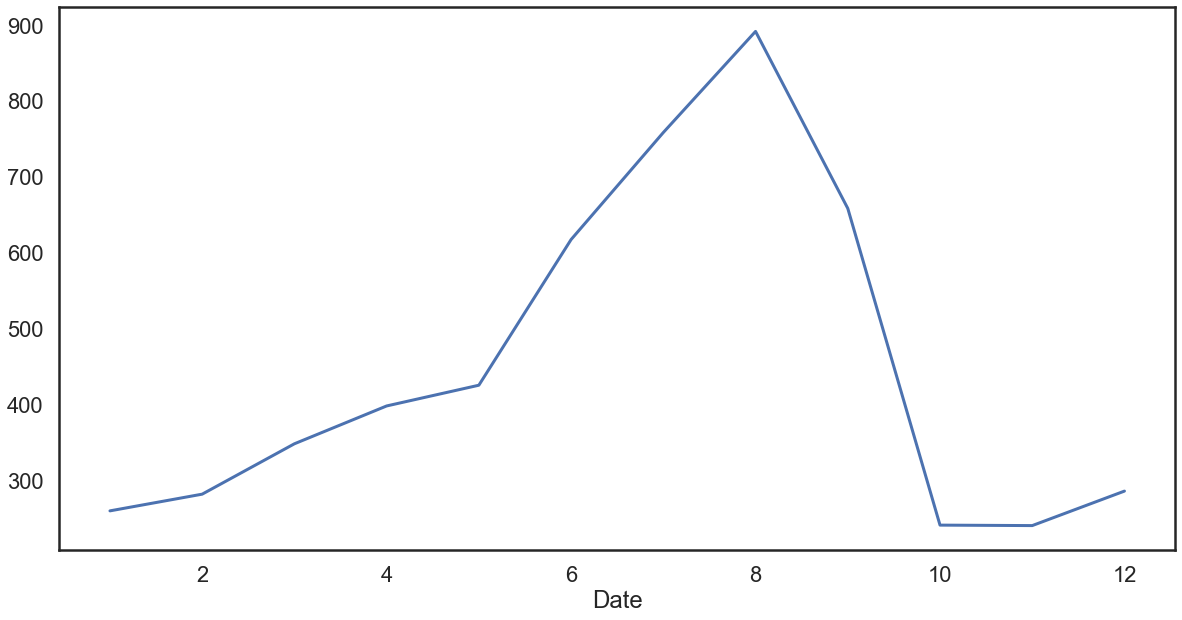

In [937]:
df2.groupby(df2.Date.dt.month)['revenue_7D'].sum().plot();


In [938]:
revenue_per_year = ( df2.groupby(['Station Name', df2.Date.dt.month])['revenue_7D']
                        .sum()
                        .unstack(level=0)
                        .reset_index()
                   )

In [939]:
revenue_per_year = ( pd.melt(revenue_per_year, id_vars="Date")
                        .rename(columns={'value': "revenue ($)"})
                   )

### compare seasonal patterns across different stations 

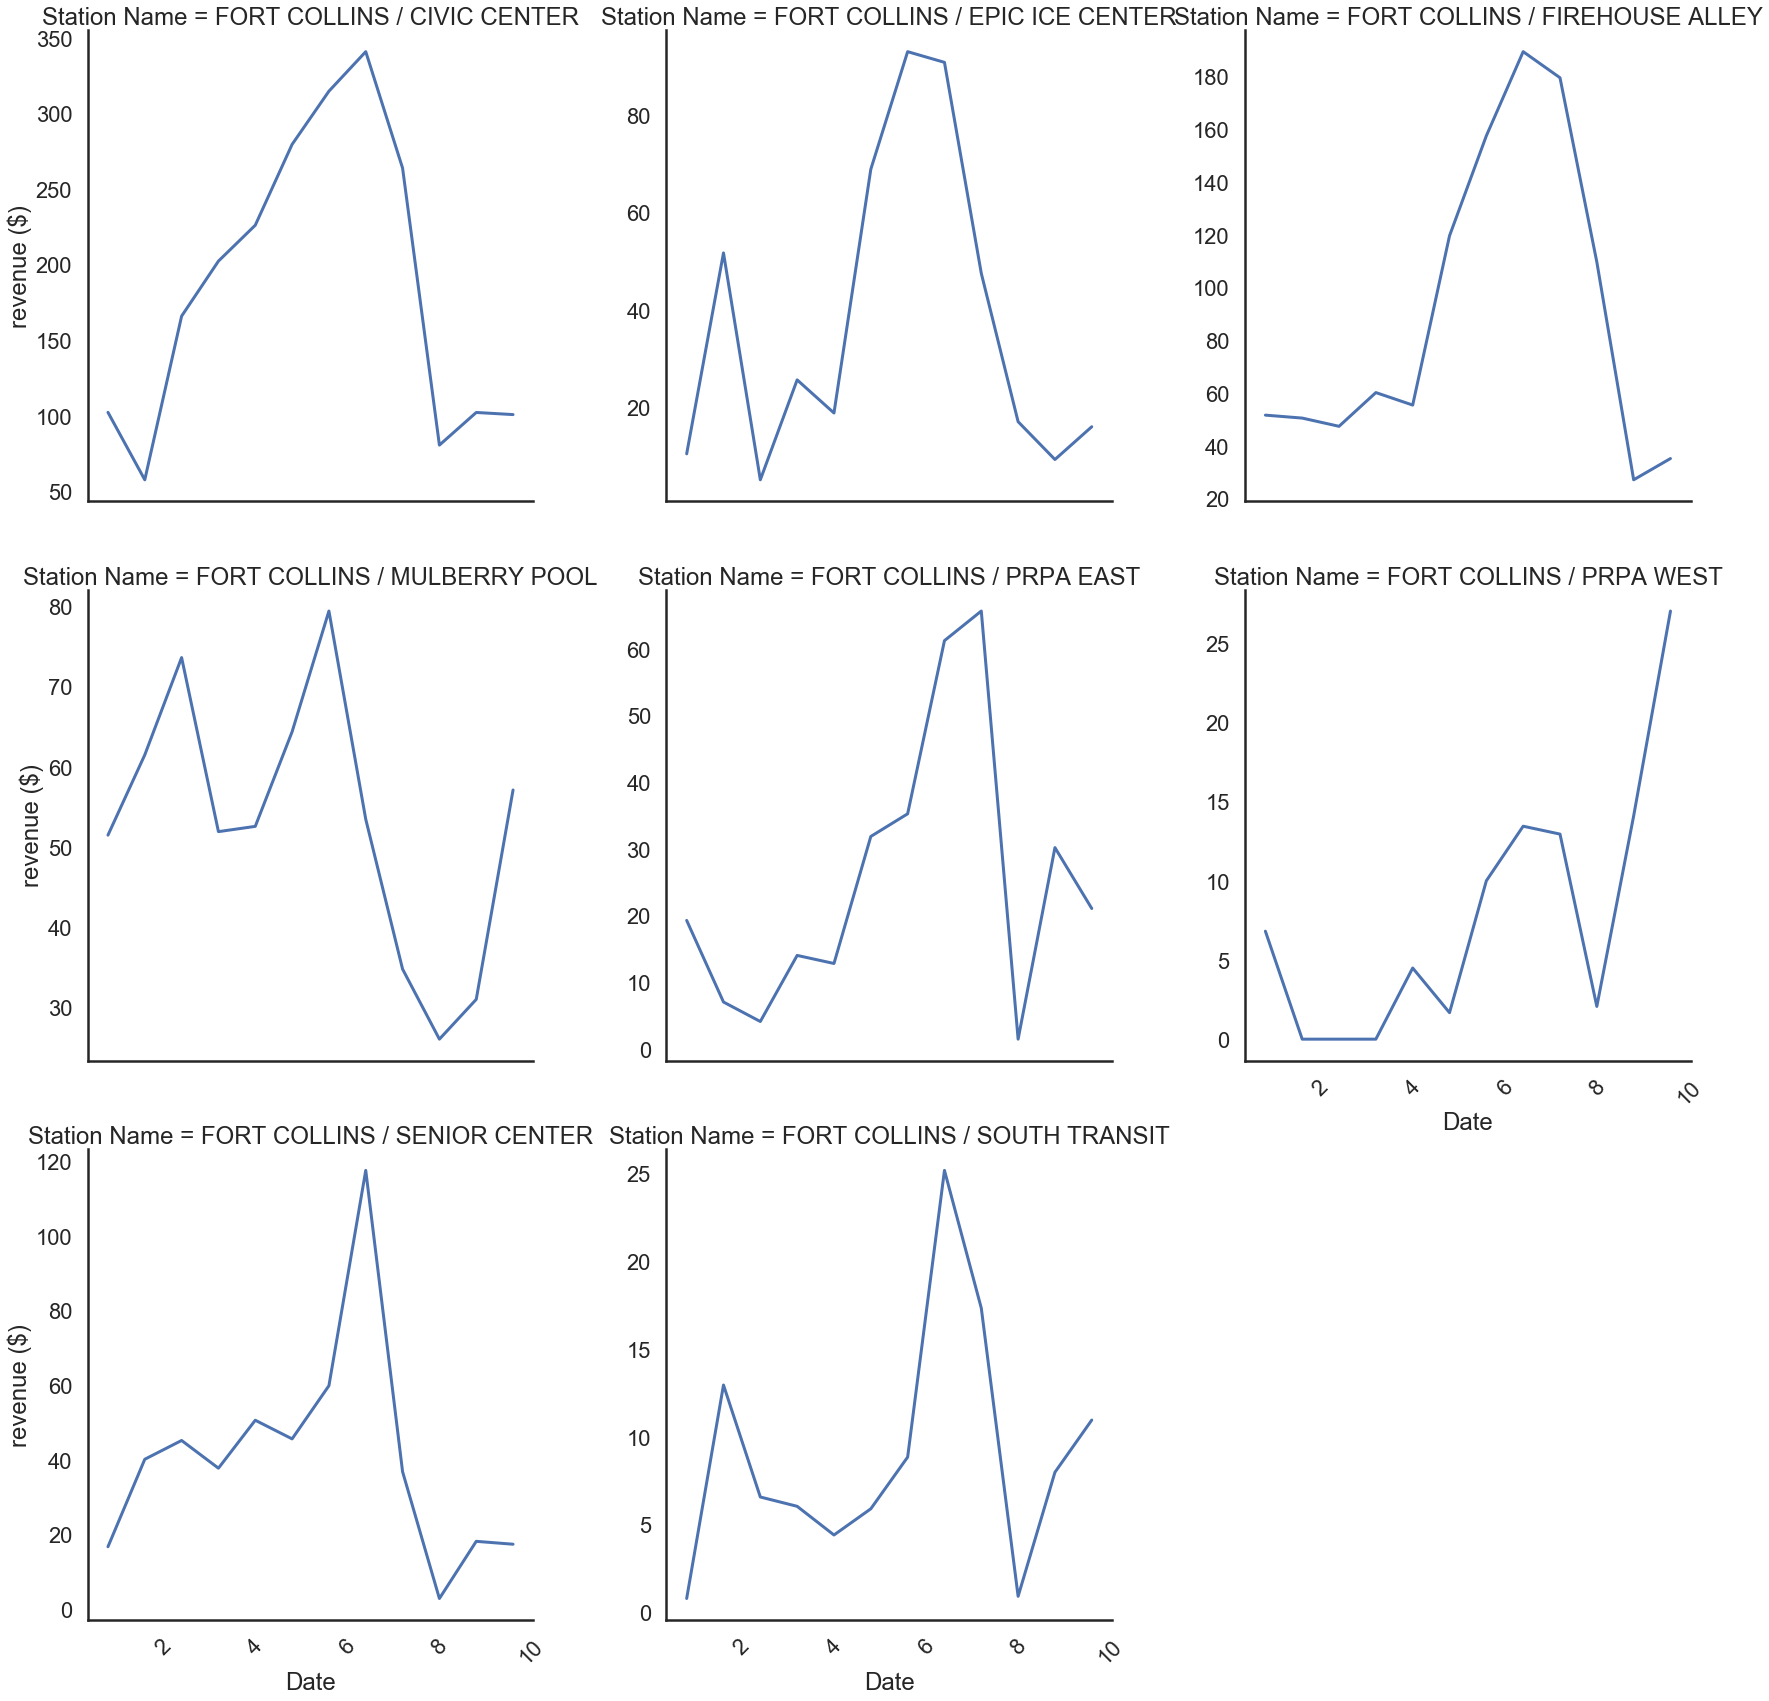

In [940]:
with sns.axes_style("white"):
    g = sns.FacetGrid(revenue_per_year, col="Station Name", margin_titles=True, 
                      height=8, sharey=False, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue ($)")
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45);
    
g.add_legend();

# 3. Day of week 
## revenue is highest on mondays and dips midweek

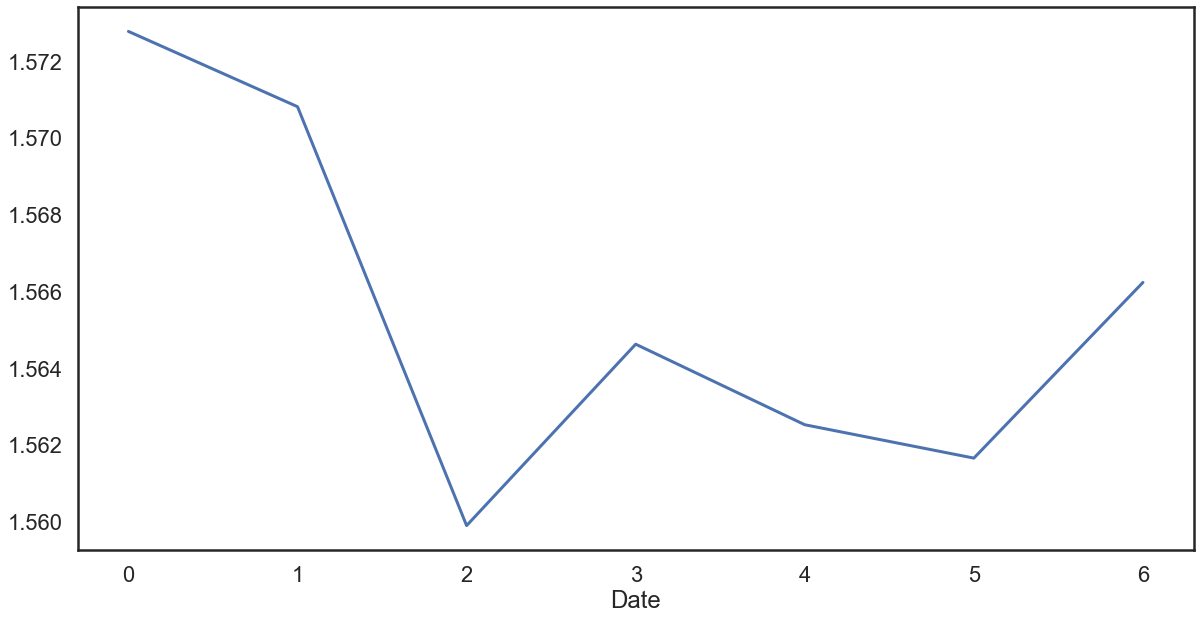

In [875]:
df2.groupby(df2.Date.dt.dayofweek)['revenue_7D'].mean().plot();
# The day of the week with Monday=0, Sunday=6.

In [161]:
revenue_per_year = ( df2.groupby(['Station Name', df2.Date.dt.dayofweek])['revenue_7D']
                        .mean()
                        .unstack(level=0)
                        .reset_index()
                   )

In [162]:
revenue_per_year = ( pd.melt(revenue_per_year, id_vars="Date")
                        .rename(columns={'value': "revenue ($)"})
                   )

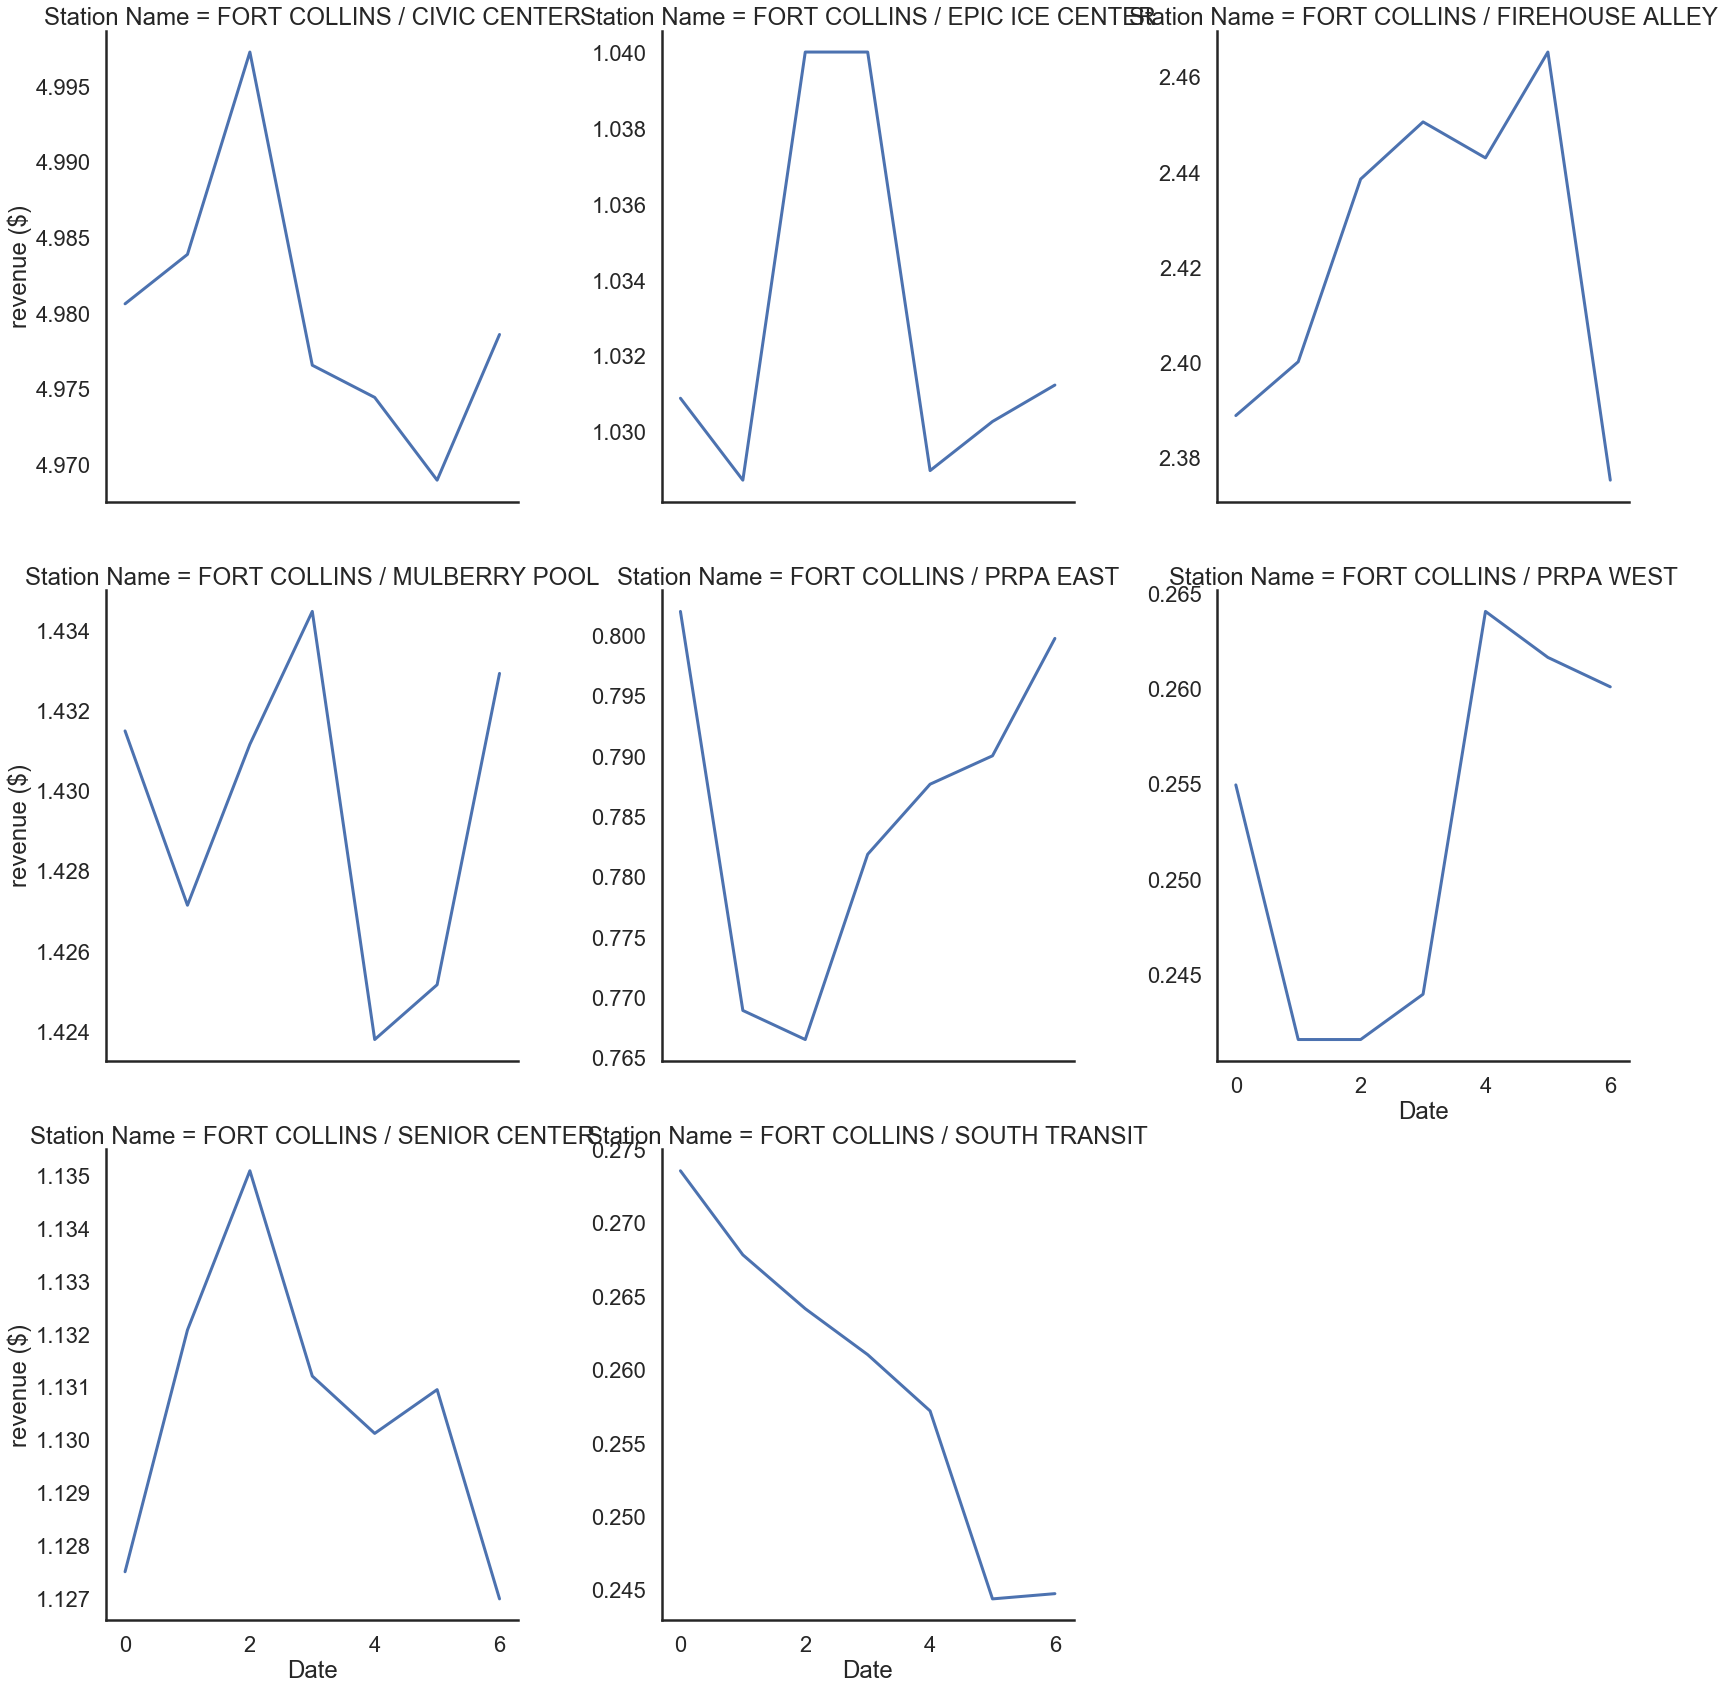

In [163]:
with sns.axes_style("white"):
    g = sns.FacetGrid(revenue_per_year, col="Station Name", margin_titles=True, 
                      height=8, sharey=False, col_wrap=3)
    
g.map(sns.lineplot, "Date", "revenue ($)")



# 4. Holidays 
## Do stations make more money on holidays (Christmas and New year)?

In [876]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
usb = CustomBusinessDay(calendar = USFederalHolidayCalendar())
holidays = pd.date_range('12/1/2020', '1/5/2021', freq=usb)

In [877]:
df3 = (df[['Net Revenue']]
       .resample('1D')
       .sum()
       .assign(Date=lambda x: x.index)
)

# 7-day rolling window
df3["Net Revenue"] = df3['Net Revenue'].\
                         transform(lambda x: x.rolling('7D', closed='both', center=True).mean())

In [878]:
df3

,Net Revenue,Date
Date,,
2020-06-25,3.217500,2020-06-25
2020-06-26,3.732000,2020-06-26
2020-06-27,3.110000,2020-06-27
2020-06-28,2.851429,2020-06-28
2020-06-29,2.478571,2020-06-29
...,...,...
2021-09-17,25.042857,2021-09-17
2021-09-18,23.225714,2021-09-18
2021-09-19,22.766667,2021-09-19


In [880]:
df3['Holiday'] = ~df3['Date'].isin(holidays)


In [881]:
df3.groupby('Holiday')['Net Revenue'].mean()

Holiday
False     9.180060
True     12.059715
Name: Net Revenue, dtype: float64

### Significant relationship between holiday feature and the number of customers per day

In [882]:

# using the Kruskal Wallis H test for differences between groups with unequal sample sizes 
kruskal(df3['Holiday'], df3['Net Revenue'])

KruskalResult(statistic=761.0974243856241, pvalue=1.5504057870680945e-167)

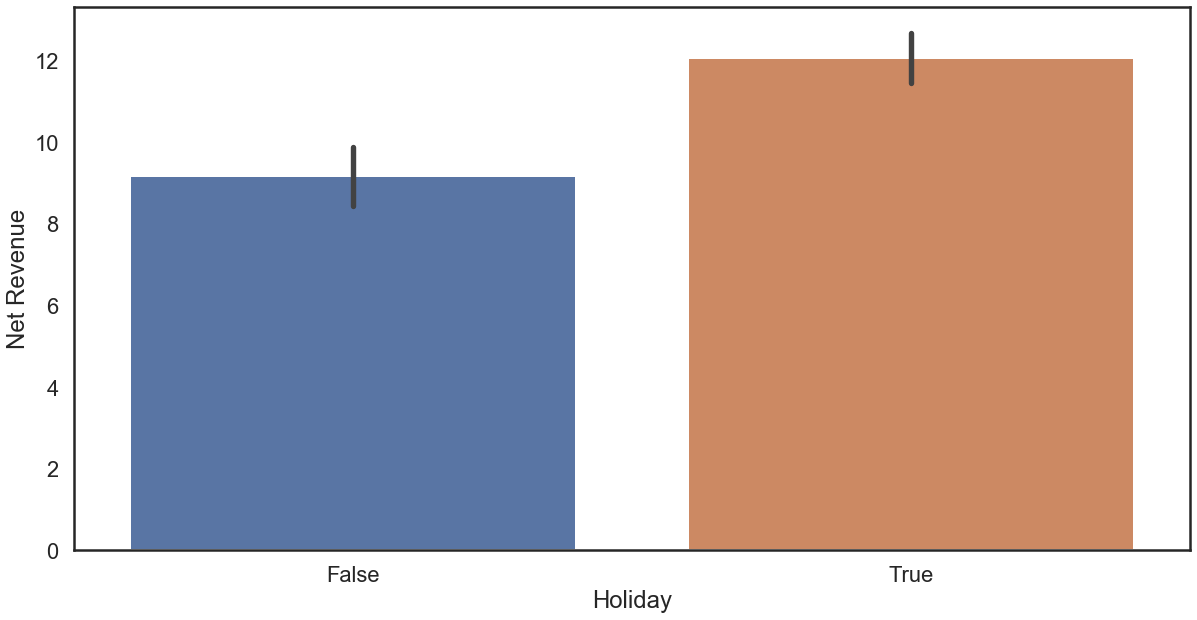

In [839]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sns.barplot(data = df3, x='Holiday', y='Net Revenue');

# 5. Is weekend a predictor of revenue?

In [468]:
df3 = (df['Net Revenue']
       .resample('1D')
       .sum()
       .reset_index()
)

In [469]:
df3['weekday'] = df3['Date'].apply(lambda x: x.weekday())

In [470]:
df3['is_weekend'] = df3['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)


In [471]:
df3

,Date,Net Revenue,weekday,is_weekend
0,2020-06-25,4.41,3,0
1,2020-06-26,3.66,4,0
2,2020-06-27,3.61,5,0
3,2020-06-28,1.19,6,1
4,2020-06-29,5.79,0,1
...,...,...,...,...
449,2021-09-17,39.33,4,0
450,2021-09-18,32.26,5,0
451,2021-09-19,19.61,6,1
452,2021-09-20,19.29,0,1


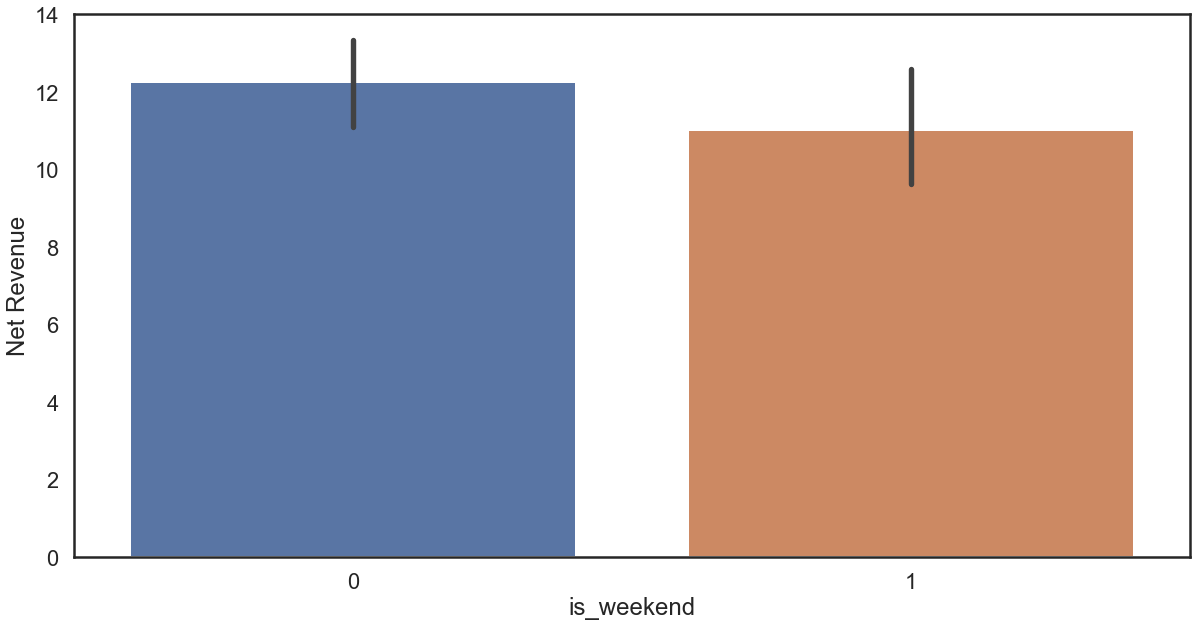

In [474]:
sns.barplot(data = df3, x = 'is_weekend', y = 'Net Revenue');


In [449]:
# Correlation between working_day feature and the number of customers per day
# using the Kruskal Wallis H test for correlations between a continuous and categorical variable
# It is used for comparing two or more independent samples of equal or different sample sizes.
kruskal(df3['is_weekend'], df3['Net Revenue'])

KruskalResult(statistic=648.6700520064156, pvalue=4.348596401707682e-143)

In [452]:
df3.groupby('is_weekend')['Net Revenue'].median()

is_weekend
0    9.44
1    9.32
Name: Net Revenue, dtype: float64

# 6. Weather 
## Is temperature a predictor of revenue?

In [930]:
df3 = (df['Net Revenue']
       .resample('1D')
       .sum()
       .reset_index()
)

In [931]:
df3['TOBS'] = (df['TOBS']
       .resample('1D')
       .mean()
       .reset_index()
)['TOBS']

In [932]:
df3 = df3.dropna()

### correlation between the different temperature features and total_revenue

In [933]:
print('temp_avg:', pearsonr(df3['TOBS'], df3['Net Revenue']))

temp_avg: (0.20973366243289615, 6.899612969230601e-06)


In [934]:
reduced_df = (df3[['TOBS','Net Revenue']][250:])

Text(0.5, 0, 'time')

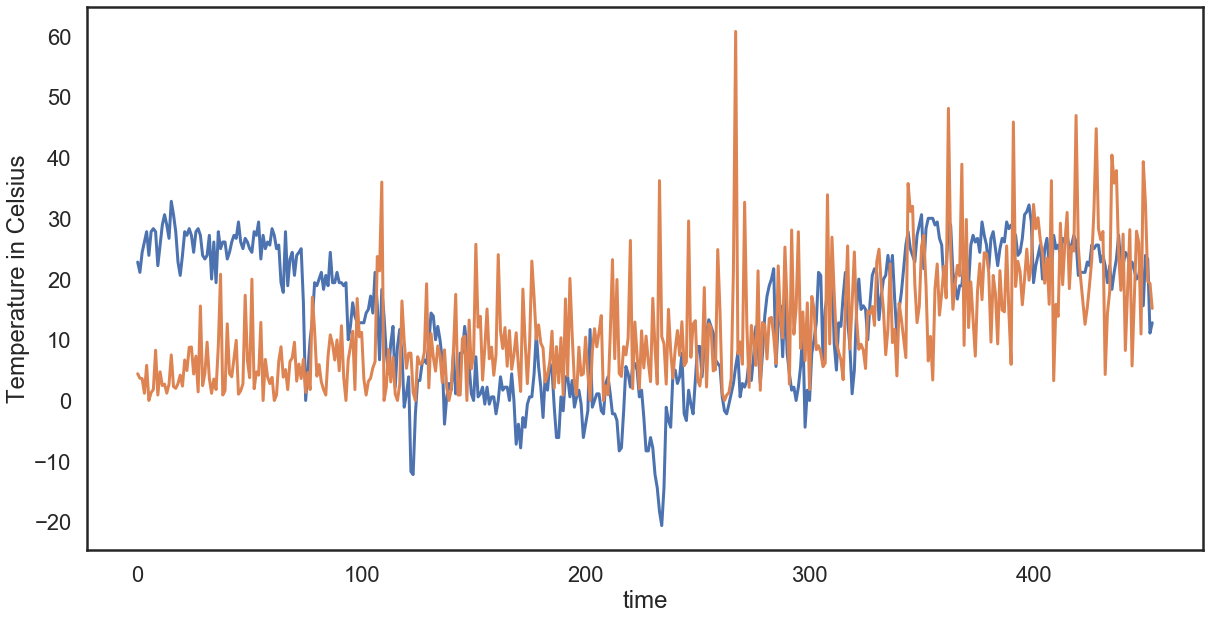

In [935]:


plt.plot(df3['TOBS'])
plt.plot(df3['Net Revenue'])
plt.ylabel('Temperature in Celsius')
plt.xlabel('time')

### another way to look at this: temperature categories

In [857]:
df_cat = reduced_df.copy()
# temperature is in 
df_cat['very_cold'] = df_cat['TOBS'].apply(lambda x: 1 if x < 0 else 0)
df_cat['cold'] = df_cat['TOBS'].apply(lambda x: 1 if x < 10 and x >= 0 else 0)
df_cat['cool'] = df_cat['TOBS'].apply(lambda x: 1 if x < 20 and x >= 10 else 0)
df_cat['warm'] = df_cat['TOBS'].apply(lambda x: 1 if x < 30 and x >= 20 else 0)
df_cat['hot'] = df_cat['TOBS'].apply(lambda x: 1 if x >= 30 else 0)

In [858]:
df_cat

,TOBS,Net Revenue,very_cold,cold,cool,warm,hot
250,8.9,3.49,0,1,0,0,0
251,8.9,2.39,0,1,0,0,0
252,3.9,5.58,0,1,0,0,0
253,8.9,18.60,0,1,0,0,0
254,11.1,2.22,0,0,1,0,0
...,...,...,...,...,...,...,...
449,15.6,39.33,0,0,1,0,0
450,23.9,32.26,0,0,0,1,0
451,23.3,19.61,0,0,0,1,0
452,11.1,19.29,0,0,1,0,0


### Revenue is lowest when temperature below freezing

Text(0, 0.5, 'Revenue')

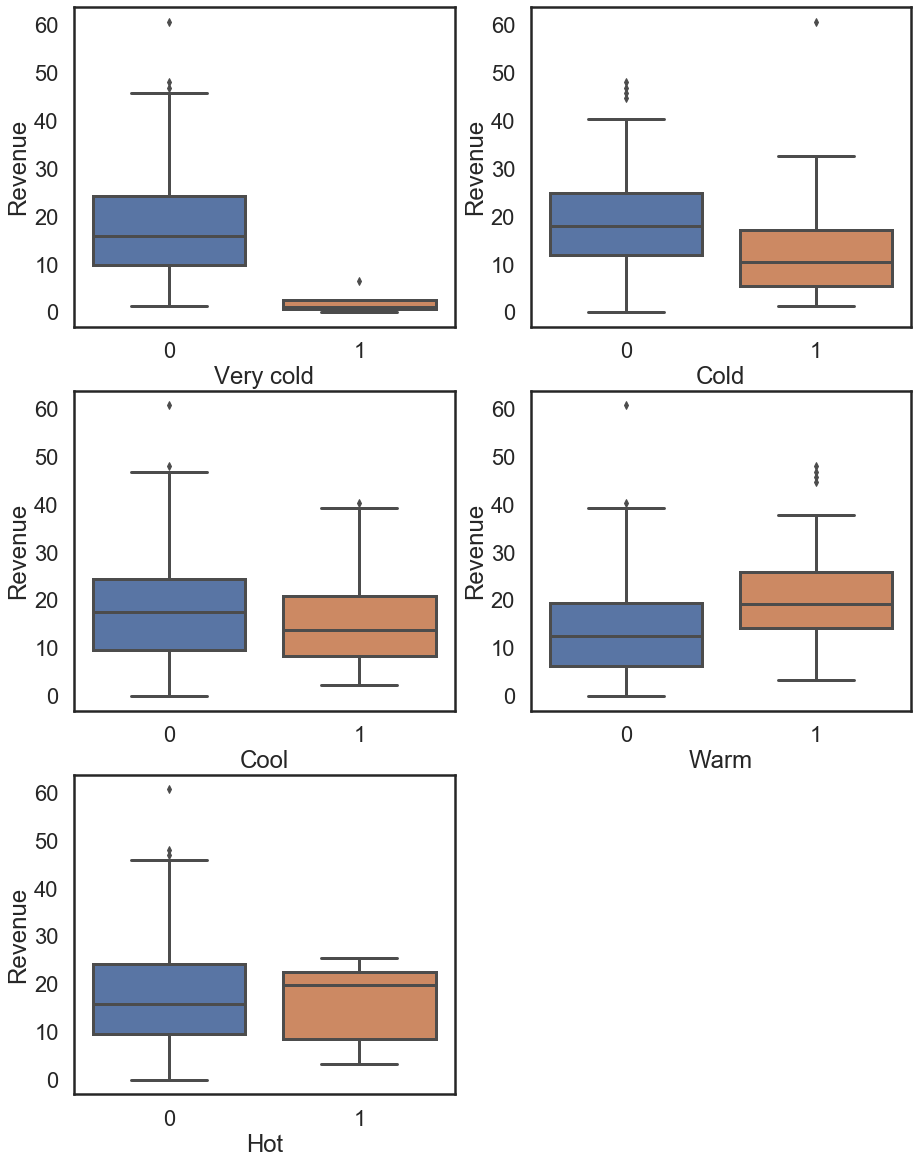

In [859]:
plt.figure(figsize=[15,20])
plt.subplot(3,2,1)
sns.boxplot(data=df_cat, x='very_cold', y='Net Revenue')
plt.xlabel('Very cold')
plt.ylabel('Revenue')

plt.subplot(3,2,2)
sns.boxplot(data=df_cat, x='cold', y='Net Revenue')
plt.xlabel('Cold')
plt.ylabel('Revenue')

plt.subplot(3,2,3)
sns.boxplot(data=df_cat, x='cool', y='Net Revenue')
plt.xlabel('Cool')
plt.ylabel('Revenue')

plt.subplot(3,2,4)
sns.boxplot(data=df_cat, x='warm', y='Net Revenue')
plt.xlabel('Warm')
plt.ylabel('Revenue')

plt.subplot(3,2,5)
sns.boxplot(data=df_cat, x='hot', y='Net Revenue')
plt.xlabel('Hot')
plt.ylabel('Revenue')

# 7. Covid case counts are a strong predictor of revenue
cases started going down in April-May 2021 and increased by $12/day, which was equivalent to the increase seen over the last year during covid (July 2020 - April 2021). Covid obviously slowed down the growth of these stations

In [885]:
df3 = (df[['Net Revenue', 'cases_per_100k']]
       .resample('1D')
       .agg({'Net Revenue': 'sum', 'cases_per_100k': 'max'})
)
df3 = df3.fillna(method="bfill")

In [886]:
# 7-day rolling window
df3["Net Revenue"] = df3['Net Revenue'].\
                         transform(lambda x: x.rolling('30D', closed='both', center=True).mean())

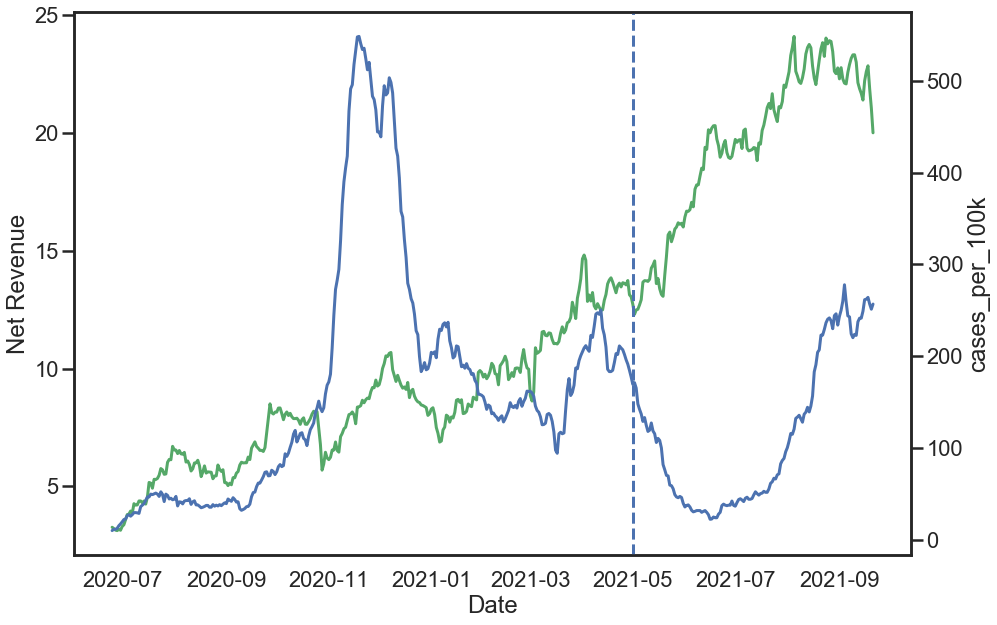

In [887]:
plt.subplots(figsize=[15, 10])
sns.lineplot(data=df3["Net Revenue"], color="g")
ax2 = plt.twinx()
sns.lineplot(data=df3['cases_per_100k'], color="b", ax=ax2)
plt.axvline(x=datetime.datetime(2021,5,1), ls='--')


### Negative correlation between covid cases and Net revenue 

In [888]:
pearsonr(df3["Net Revenue"][175:], df3['cases_per_100k'][175:])

(-0.24031950158381987, 4.9984569422569895e-05)

In [889]:
# df3_ = df3.iloc[175:]

# Encoding 7-day average case counts per 100k into categorical threat levels
the threat levels were taken from https://covid19.colorado.gov/data/covid-19-dial-dashboard

In [890]:
df_cat = df3.copy()
df_cat['low'] = df_cat['cases_per_100k'].apply(lambda x: 1 if x < 36 else 0)
df_cat['caution'] = df_cat['cases_per_100k'].apply(lambda x: 1 if x < 100 and x >= 36 else 0)
df_cat['concern'] = df_cat['cases_per_100k'].apply(lambda x: 1 if x < 300 and x >= 101 else 0)
df_cat['high'] = df_cat['cases_per_100k'].apply(lambda x: 1 if x < 500 and x >= 301 else 0)
df_cat['severe'] = df_cat['cases_per_100k'].apply(lambda x: 1 if x >= 501 else 0)

In [891]:
df_cat = df_cat.reset_index()

In [892]:
df_cat['risk'] = df_cat[['low', 'caution', 'concern', 'high', 'severe']].idxmax(axis=1)


In [893]:
df_cat

,Date,Net Revenue,cases_per_100k,low,caution,concern,high,severe,risk
0,2020-06-25,3.264375,9.799184,1,0,0,0,0,low
1,2020-06-26,3.207647,11.199067,1,0,0,0,0,low
2,2020-06-27,3.140556,11.199067,1,0,0,0,0,low
3,2020-06-28,3.121579,12.318974,1,0,0,0,0,low
4,2020-06-29,3.174500,15.118741,1,0,0,0,0,low
...,...,...,...,...,...,...,...,...,...
449,2021-09-17,22.602000,262.058176,0,0,1,0,0,concern
450,2021-09-18,22.849474,264.018013,0,0,1,0,0,concern
451,2021-09-19,21.873333,256.738619,0,0,1,0,0,concern
452,2021-09-20,21.054706,251.139085,0,0,1,0,0,concern


### How many days in each COVID threat level?

In [894]:
df_cat.groupby('risk').agg({'Net Revenue': 'size'})

,Net Revenue
risk,
caution,136
concern,229
high,28
low,49
severe,12


### How much daily revenue was generated during each COVID threat level?

In [895]:
risk = df_cat.groupby('risk')['Net Revenue'].mean().reset_index()

In [896]:
risk_df = risk.sort_values(by='Net Revenue', ascending=False)

In [897]:
risk_df

,risk,Net Revenue
1,concern,13.043376
0,caution,11.322009
3,low,10.651585
2,high,9.088295
4,severe,8.654839


### High and Severe covid levels had the lowest daily revenue 
it's not a 1:1 relationship, maybe there's a time lag? 
or other external factors like weather


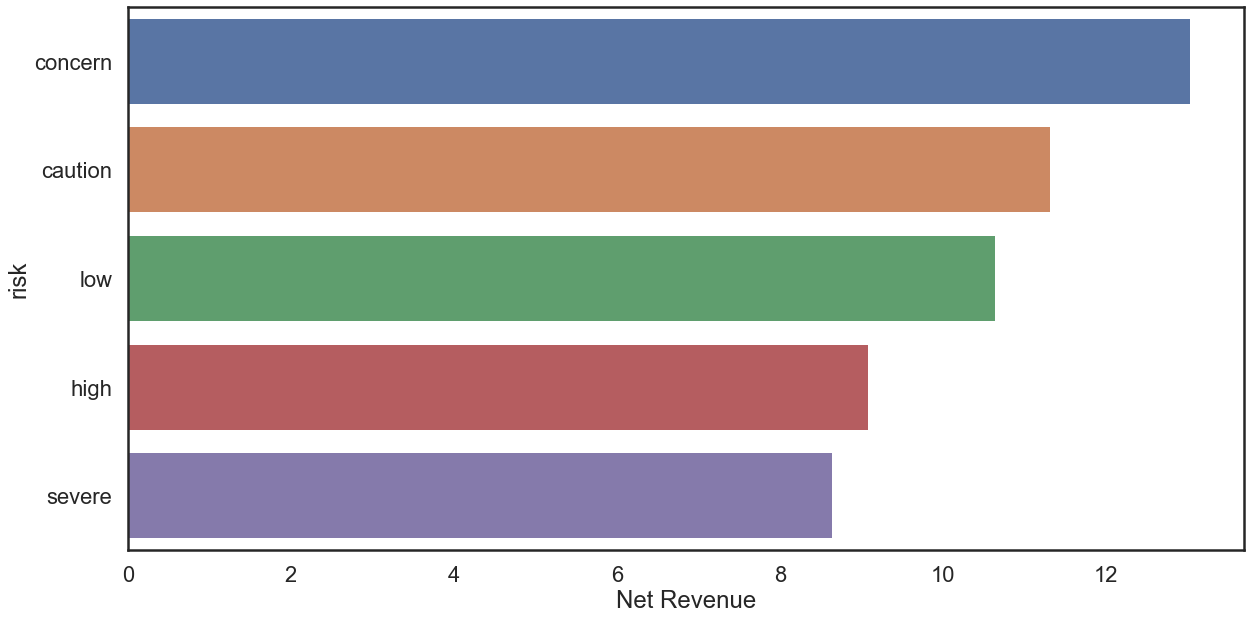

In [898]:
sns.barplot(data=risk_df, y='risk', x='Net Revenue');

### Are there significant differences in revenue between these covid categories?

one-way anova with 5 categories with follow-up t-tests 

In [916]:
f_oneway(df_cat.loc[df_cat.risk=='low', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='concern', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='caution', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='high', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='severe', 'Net Revenue'])

F_onewayResult(statistic=5.647302257550961, pvalue=0.00019248096681081397)

## There is a statistically significant difference between the covid threat level groups and their effects on revenue, F= 5.64, p-value= 0.0002

In [918]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_cat['Net Revenue'], df_cat['risk'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
caution,concern,1.7214,0.0519,-0.0085,3.4512,False
caution,high,-2.2337,0.3495,-5.5498,1.0824,False
caution,low,-0.6704,0.9,-3.3328,1.992,False
caution,severe,-2.6672,0.5443,-7.4792,2.1448,False
concern,high,-3.9551,0.0069,-7.1542,-0.756,True
concern,low,-2.3918,0.0714,-4.9069,0.1233,False
concern,severe,-4.3885,0.0839,-9.1206,0.3436,False
high,low,1.5633,0.7635,-2.2222,5.3488,False
high,severe,-0.4335,0.9,-5.9468,5.0799,False
low,severe,-1.9967,0.8022,-7.1435,3.15,False


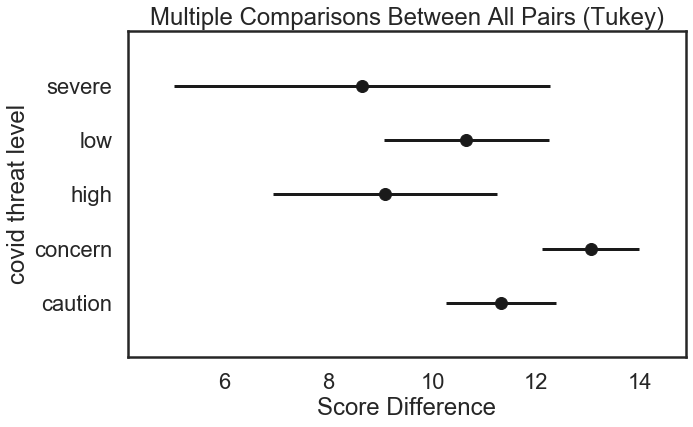

In [920]:
post_hoc_res.plot_simultaneous(ylabel= "covid threat level", xlabel= "Score Difference");

##  Statistically significant difference in revenue score between covid risk levels in the 'concern' category and the 'high' category

The Kruskal-Wallis test is a nonparametric version of the one-way analysis of variance test or ANOVA for short. It is named for the developers of the method, William Kruskal and Wilson Wallis. This test can be used to determine whether more than two independent samples have a different distribution. It can be thought of as the generalization of the Mann-Whitney U test.

The default assumption or the null hypothesis is that all data samples were drawn from the same distribution. Specifically, that the population medians of all groups are equal. A rejection of the null hypothesis indicates that there is enough evidence to suggest that one or more samples dominate another sample, but the test does not indicate which samples or by how much.

In [928]:
stat, p = kruskal(df_cat.loc[df_cat.risk=='low', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='concern', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='caution', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='high', 'Net Revenue'],
         df_cat.loc[df_cat.risk=='severe', 'Net Revenue'])
print('Statistics=%.3f, p=%.9f' % (stat, p))

Statistics=39.900, p=0.000000045


In [929]:
tbl, a1, a2 = comp.allpairtest(ttest_ind, method= "sidak")

tbl

group1,group2,stat,pval,pval_corr,reject
caution,concern,-2.6883,0.0075,0.0726,False
caution,high,1.8496,0.0662,0.4959,False
caution,low,0.6083,0.5437,0.9996,False
caution,severe,1.4478,0.1498,0.8027,False
concern,high,3.7,0.0003,0.0026,True
concern,low,2.5514,0.0113,0.1072,False
concern,severe,2.6912,0.0076,0.0737,False
high,low,-1.1256,0.2639,0.9533,False
high,severe,1.3269,0.1924,0.882,False
low,severe,0.9421,0.35,0.9865,False


# The statistical test is basically discriminating between everything before May 2021, which were in the high levels and everything after May 2021 when covid cases started to come down and are currently in the concern levels 